In [24]:
import os
from os.path import expanduser
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import shutil
from shapely import Point
from joblib import Parallel, delayed as delayed_joblib
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt

In [25]:
base_path = expanduser("/home/patel_zeel/OpenAQ/PurpleAir/purpleair_california.nc")
ds = xr.open_dataset(base_path, chunks="auto").load()
ds

<xarray.Dataset>
Dimensions:      (time: 44350, station: 11618)
Coordinates:
  * time     (time) time64[ns] 2018-03-25T18:00:00 ... 2023-04-16...
  * station  (station) int64 61935 61938 61942 ... 1637277 1658374
    lat          (station) float64 33.94 38.37 37.57 ... 40.02 39.55 34.04
    lon          (station) float64 -117.4 -122.5 -122.3 ... -123.4 -118.3
Data variables:
    value        (time, station) float64 nan nan nan nan ... nan nan nan

(32.0, 43.0)

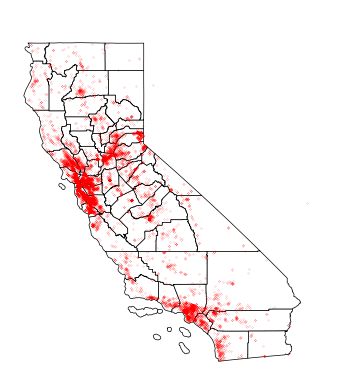

In [29]:
cal_map = gpd.read_file(f"/home/patel_zeel/aqmsp/aqmsp_data/datasets/shapefiles/california/CA_Counties_TIGER2016.shp")
# convert to lat/lon
cal_map = cal_map.to_crs(epsg=4326)

# fig, ax = plt.subplots(1, 2)
# cal_map.plot(ax=ax[0], color='white', edgecolor='black', linewidth=0.5)
cal_map.plot(color='white', edgecolor='black', linewidth=0.5)

# plot lat/lon
plt.scatter(ds['lon'], ds['lat'], s=0.01, c='red')
plt.axis('off')
plt.xlim(-125, -113)
plt.ylim(32, 43)

(-120.0, -117.0, 33.1, 35.0)

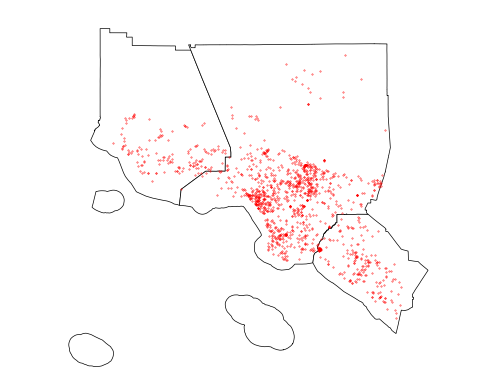

In [38]:
cities = ["Los Angeles", "Orange", "Ventura"]
# plt.scatter(ds['lon'], ds['lat'], s=0.1, c='red')
subset_map = cal_map[cal_map.NAME.isin(cities)]
subset_map.plot(color='white', edgecolor='black', linewidth=0.5)
# scatter all points within the subset
for lat, lon in zip(ds['lat'], ds['lon']):
    if subset_map.contains(Point(lon, lat)).any():
        plt.scatter(lon, lat, s=0.1, c='red')

plt.xlim(-120, -117)
plt.ylim(33.1, 35)
plt.axis('off')

In [15]:
# find all points in LA by using the lat/lon
unary = subset_map.geometry.unary_union

def find_points_in_subset(lon, lat, id):
    if unary.contains(Point(lon, lat)):
        return id.item()
    else:
        return None

subset_stations = Parallel(32)([delayed_joblib(find_points_in_subset)(lon, lat, id) for lon, lat, id in zip(ds['lon'], ds['lat'], ds['station'])])
subset_stations = [x for x in subset_stations if x is not None]
len(subset_stations)
# subset_map.geometry.unary_union.contains(Point(-118.243683, 34.052235))

1301

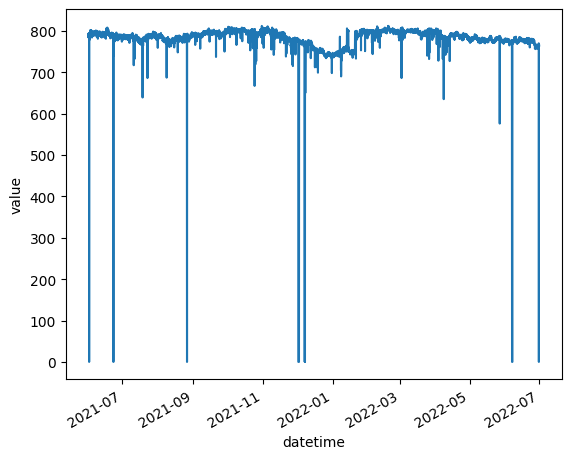

In [16]:
subset_ds = ds.sel(station=subset_stations, time = slice('2021-06-01', '2022-06-30'))
# convert station to string
subset_ds['station'] = subset_ds['station'].astype(str)

# plot number of stations which have non-null values for each time
subset_ds["value"].notnull().sum(dim='station').plot()

### Remove sensors with most null values

In [17]:
nonull_ds = (subset_ds.isnull().sum(dim="time")/subset_ds.time.size) < 0.95
nonull_ds = nonull_ds.where(nonull_ds, drop=True)

nonull_subset_ds = subset_ds.sel(station=nonull_ds.station.values)
nonull_subset_ds

<xarray.Dataset>
Dimensions:      (time: 9480, station: 1046)
Coordinates:
  * time     (time) time64[ns] 2021-06-01 ... 2022-06-30T23:00:00
  * station  (station) <U21 '61982' '62064' ... '351628' '351634'
    lat          (station) float64 34.02 33.84 34.07 ... 33.81 33.75 33.83
    lon          (station) float64 -118.5 -118.3 -118.2 ... -118.3 -118.3
Data variables:
    value        (time, station) float64 10.12 nan 48.81 ... 12.73 14.1

### Remove dates with extremely low number of sensors

In [18]:
nonull_ts = nonull_subset_ds["value"].notnull().sum(dim='station') > 720 # this number was chosen iteratively to ensure we don't have too many null values per timestamp
nonull_ts = nonull_ts[nonull_ts]

processed_ds = nonull_subset_ds.sel(time=nonull_ts.time.values)
processed_ds

<xarray.Dataset>
Dimensions:      (time: 9417, station: 1046)
Coordinates:
  * time     (time) time64[ns] 2021-06-01 ... 2022-06-30T23:00:00
  * station  (station) <U21 '61982' '62064' ... '351628' '351634'
    lat          (station) float64 34.02 33.84 34.07 ... 33.81 33.75 33.83
    lon          (station) float64 -118.5 -118.3 -118.2 ... -118.3 -118.3
Data variables:
    value        (time, station) float64 10.12 nan 48.81 ... 12.73 14.1

### Remove sensors with extremely high values

In [20]:
max_ds = processed_ds["value"].max(dim="time")
bad_idx = max_ds > 175 # was 800
print("Number of bad stations: ", bad_idx.sum().values)

clean_locs = processed_ds.station.values[~bad_idx.values]
print(len(clean_locs))
clean_ds = processed_ds.sel(station=clean_locs)

locations_to_remove = ['221712', '221714']  # duplicate stations
locs_to_choose = list(set(clean_ds.station.values) - set(locations_to_remove))
clean_ds = clean_ds.sel(station=locs_to_choose)

print(clean_ds.value.max())
clean_ds

Number of bad stations:  332
714
<xarray.DataArray 'value' ()>
array(174.63571429)


<xarray.Dataset>
Dimensions:      (time: 9417, station: 714)
Coordinates:
  * time     (time) time64[ns] 2021-06-01 ... 2022-06-30T23:00:00
  * station  (station) <U21 '69906' '62194' ... '274967' '229256'
    lat          (station) float64 33.99 34.07 34.24 ... 34.21 33.7 33.84
    lon          (station) float64 -118.2 -118.2 -119.0 ... -117.8 -118.3
Data variables:
    value        (time, station) float64 nan 48.81 19.85 ... 5.775 nan

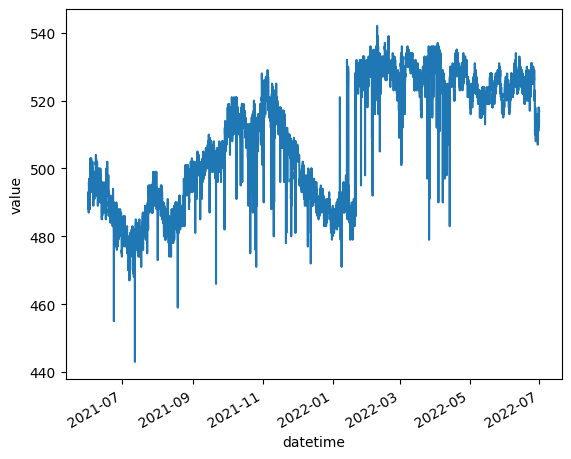

In [21]:
clean_ds["value"].notnull().sum(dim='station').plot()

In [22]:
region = "lov_175"
tmp_save_path = f"/opt/aqmsp_models/data/purpleair/{region}/data.nc"
os.makedirs(os.path.dirname(tmp_save_path), exist_ok=True)
clean_ds.to_netcdf(tmp_save_path)

## Divide into folds

In [23]:
locs = clean_ds.station.values
for fold_id, (test_idx, train_idx) in enumerate(KFold(n_splits=5, shuffle=True, random_state=0).split(locs)):
    print(len(test_idx), len(train_idx))
    tmp_save_path = f"/opt/aqmsp_models/data/purpleair/{region}/test_{fold_id}.npy"
    np.save(tmp_save_path, locs[test_idx])
    tmp_save_path = f"/opt/aqmsp_models/data/purpleair/{region}/train_{fold_id}.npy"
    np.save(tmp_save_path, locs[train_idx])

571 143
571 143
571 143
571 143
572 142
